# 18HEUR - GA for training ANN

### Miroslav Kubů

kubumiro@fjfi.cvut.cz

# Goal

<ul>
    <li>train artificial neural network using genetic algorithm </li>
    <li> measure of the performance of the classification - accuracy </li>
</ul>


In [1]:
#import GA 
#import AN 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

We use IRIS training dataset for two classes. The matching inputs are stores in the first 100 observations. Thus, we want to perform a statistical binary classification task using an ANN.

In [2]:
iris = datasets.load_iris()
X= iris.data[:100, :] #input
Y = iris.target[:100] #target

In [3]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

# AN.py

In [4]:
import numpy as np

For the ANN model prediction, we firstly define the activation functions. In our case, we use ReLU activation function for hidden layers.

\begin{equation}
    \textrm{ReLU} (x) = \begin{cases}
    x &\mbox{if } x \geq 0 \\
    0 & \mbox{if } x <  0 \end{cases}.
\end{equation}

For the output layer, the sigmoid activation function is used.

\begin{equation}
f(x) = \frac{1}{1+e^{-x}}.
\end{equation}

The output of sigmoid can be later interpreted as the probability of an input belonging to the first class.

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1 * x))

def relu(x):
    result = x
    result[x < 0] = 0
    return result

Within the `predict_outputs` function, we calculate the ANN predictions as well as overall accuracy

\begin{equation}
    ACC = \frac{\#\textrm{correctly predicted}}{\#\textrm{total}}.
\end{equation}

The idea of this function is using matrix multiplication of an input with the weights of each layer and then transform it with the activation function.

In [5]:
def predict_outputs(weights_mat, inputs, outputs, activation="relu"):
    Y_pred = np.zeros(shape=(inputs.shape[0]))
    Y_prob = np.zeros(shape=(inputs.shape[0]))
    for i in range(inputs.shape[0]):
        x = inputs[i, :]
        for curr_weights in weights_mat:
            x = np.matmul(a=x, b=curr_weights)
            if activation == "relu":
                x = relu(x)
            elif activation == "sigmoid":
                x = sigmoid(x)
      
    #output of sigmoid function > 0.5 ---> input is considered as class 1 with prob. > 0.5
    
        if x>0.5: 
            predicted_label =1
        else:
            predicted_label=0
        Y_prob[i] = x
        Y_pred[i] = predicted_label
    correct = np.where(Y_pred == outputs)[0].size
    accuracy = (correct / outputs.size) * 100
    return accuracy, Y_pred, Y_prob

# GA.py


In [6]:
import numpy as np
import random

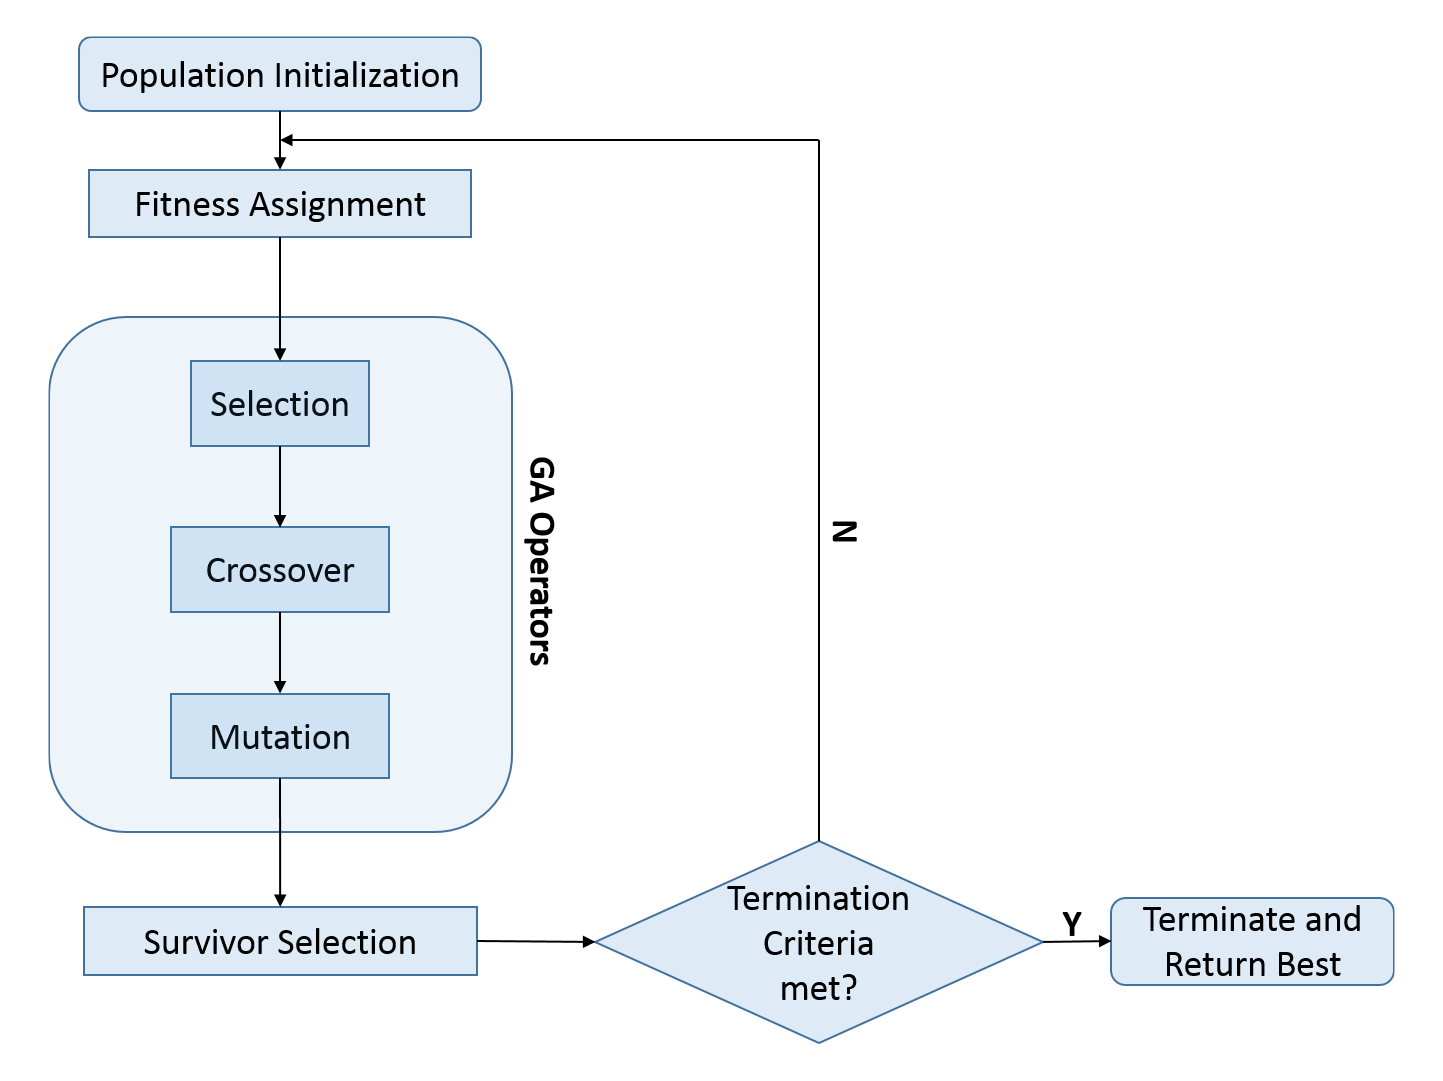

In [1]:
from IPython.display import Image
Image("ga.png")

Because matrix multiplication is used within ANN, we will still represent the ANN parameters in the matrix form when using the ANN. However we are used to perform GA operations with 1D vector. Thus, matrix form is used when working with ANN and vector form is used when working with GA. That´s why we define functions for conversion between matrix and vector form.

In [7]:
def mat_to_vector(matrix_weights):
    weights_vector = []
    for i in range(matrix_weights.shape[0]):
        curr_vector = []
        for layer_i in range(matrix_weights.shape[1]):
            vector_weights = np.reshape(matrix_weights[i, layer_i], newshape=(matrix_weights[i, layer_i].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)

def vector_to_mat(vector_weights, matrix_weights):
    mat_weights = []
    for i in range(matrix_weights.shape[0]):
        start = 0
        end = 0
        for layer_i in range(matrix_weights.shape[1]):
            end = end + matrix_weights[i, layer_i].size
            curr_vector = vector_weights[i, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(matrix_weights[i, layer_i].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=matrix_weights.shape)

GA needs to return a fitness value for each solution. The higher the fitness value the better the solution. That's why we are using accuracy as the fitness function. It is the ratio between the correctly classified samples and the total number of samples.

\begin{equation}
    ACC = \frac{\#\textrm{correctly predicted}}{\#\textrm{total}}.
\end{equation}

As the output of `fitness_pop` is basically an accuracy for selected weights, we use the `predict_outputs` function.

In [8]:
def fitness_pop(weights_matrix, inputs, outputs, activation="relu"):
    accuracy = np.empty(shape=(weights_matrix.shape[0]))
    for i in range(weights_matrix.shape[0]):
        pom_mat = weights_matrix[i, :]
        accuracy[i], _ , _ = predict_outputs(pom_mat, inputs, outputs, activation=activation)
    return accuracy

We choose the best `num_parents` parents for following crossover within the `select_mating_pool` function.

In [9]:
def select_mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_i in range(num_parents):
        max_fitness_i = np.where(fitness == np.max(fitness))
        max_fitness_i = max_fitness_i[0][0]
        parents[parent_i, :] = pop[max_fitness_i, :]
        fitness[max_fitness_i] = -1 # so that we won't use this parent again
    return parents

Then, we perform `crossover` between selected parents. We choose the number of offsprings in `offspring_size`. After we choose fitting `parent1` and `parent2`, we use `cross_percent` % of `parent1` genes for the offspring.`

In [10]:
def crossover(parents, offspring_size,cross_percent):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]*cross_percent/100)
    for k in range(offspring_size[0]):
        
        #using modulo, we choose a sequence of parents to mate
        parent1_i = k%parents.shape[0] #first parent to mate
        parent2_i = (k+1)%parents.shape[0] #second parent to mate.
        
        offspring[k, 0:crossover_point] = parents[parent1_i, 0:crossover_point] 
        offspring[k, crossover_point:] = parents[parent2_i, crossover_point:] # ]rest of the genes is taken from the 2nd parent
        
    return offspring

In addition to crossover, we perform offspring `mutation` by changing `mutation_percent` % of its chromosomes. We use random uniform number for randomly changing the chromosomes.

In [11]:
def mutation(offspring_mutation, mutation_percent):
    #numb. of chromosomes mutated
    num_mutations = np.uint8((mutation_percent*offspring_mutation.shape[1])/100) 
    
    # randomly selected indices for offspring mutation.
    mutation_indices = np.array(random.sample(range(0, offspring_mutation.shape[1]), num_mutations))
    
    # mutation changes a single gene in each offspring randomly.
    for i in range(offspring_mutation.shape[0]):
        rand_numb = np.random.uniform(-1.0, 1.0, 1) # random number to be added to the gene.
        offspring_mutation[i, mutation_indices] = offspring_mutation[i, mutation_indices] + rand_numb
    return offspring_mutation

# Main file

### Genetic algorithm parameters:

We set the initial parameters for GA. 

1.    Number of parents in mating pool
2.    Number of generations
3.    Mutation percent
4.    Crossover ratio
5.    Number of solutions per population

In [19]:
num_parents_mating = 4
num_generations = 500
mutation_percent = 10
cross_percent = 60
sol_per_pop = 10

### ANN Architecture

1. layer 1 ... 10 neurons
2. layer 2 ... 10 neurons
3. output layer ... 1 output neuron

Uniform distribution $U(0,1)$ is used for weight initialization. 


\begin{equation}
w \sim U(-0.1,0.1).
\end{equation}


In the following step, we set the initial weights (population in terms of GA) for each layer.

In [20]:
initial_pop_weights = []
data_inputs=X
data_outputs=Y


for solution in np.arange(0, sol_per_pop):
    HL1_neurons = 10 #neurons in 1st hidden layer
    input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))

    HL2_neurons = 10 #neurons in 2nd hidden layer
    HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))

    output_neurons = 1 #neurons in the output layer
    HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(np.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

### Main algorithm

Within the main algorithm, we perform following operations for each generation

1. evaluate fitness  
2. select mating pool 
3. do the crossover  
4. perform mutation 
5. settle new generation


Each solution includes the weights from each layer of the model. By default, `sol_per_pop`=10 solutions are observed for each generation. Otherwise, `mat_to_vector` and `vector_to_mat` functions are used frequently, as we need to flatten weights into vectors for each generation. The algorithm terminates if ACC = 100% or if there are no more generations left.


In [21]:
pop_weights_mat = np.array(initial_pop_weights)
pop_weights_vector = mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

for generation in range(num_generations):
        

    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    
    # fitness of population (for each solution)
    fitness = fitness_pop(pop_weights_mat, data_inputs, data_outputs,  activation="sigmoid")    
    parents = select_mating_pool(pop_weights_vector, fitness.copy(), num_parents_mating)
    offspring_crossover = crossover(parents,offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], 
                                                            pop_weights_vector.shape[1]),cross_percent=cross_percent)
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)


    # new population 
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation
    
    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    #Use weights for prediction and accuracy of current generation
    weights_current = pop_weights_mat [0, :]
    accuracies[generation],_,_ = predict_outputs(weights_current, data_inputs, data_outputs, activation="sigmoid")
    
    
    print("Generation : ", generation)
    print("Fitness: ", fitness)
    print("ACC: ", accuracies[generation])
    
    # Terminate when the accuracy is 100% 
    if accuracies[generation]==100:
        break

pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

#Use best weights for final prediction
best_weights = pop_weights_mat [0, :]
acc, predictions, probs = predict_outputs(best_weights, data_inputs, data_outputs, activation="sigmoid")
print("Final ACC is : ", acc)



Generation :  0
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  1
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  2
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  3
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  4
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  5
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  6
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  7
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  8
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  9
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  10
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  11
Fit

## Plot overall accuracy.

Finally, we plot the overall progress of fitness function (accuracy) for each generation. For the first couple of generations, the classification tends to be random. After some training time, the accuracy grows very rapidly, though.

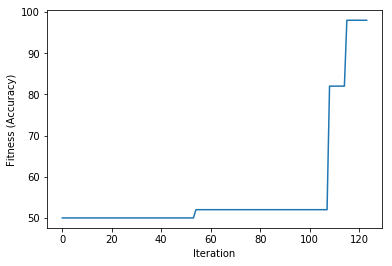

In [22]:
plt.plot(accuracies[:generation])
plt.xlabel("Iteration")
plt.ylabel("Fitness (Accuracy)")
plt.show()

In [24]:
 predictions, Y

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))

# Summary

<ul>
    <li> we successfully trained our ANN up to 100% ACC on training dataset</li>
    <li> possible extension - use validation dataset for checking the overfitting </li>
</ul>

# Literature

- Petra Vidnerová, Roman Neruda. Evolution Strategies for Deep Neural Network Models Design J. ITAT 2017 Proceedings, pp. 159–166.